This markdown covers the:
* data reading
* data imputation (optionnal)
* data preprocessing (i.e. compute informative variables)
* data one-hot encoding
* feature-scaling of the profile data frame
* dimensionality reduction of the profile dataframe
* modelling of the clusters using K-Means
* interpretation of the clusters

Author: Mickael Bastard

In [1]:
import numpy as np
import pandas as pd
import random
import imp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from yellowbrick.cluster.elbow import kelbow_visualizer

import sys
sys.path.insert(1, './../utils/')
# importing the utils_main library as utm
import utils_main as utm
import utils_pipeline as utpi
import utils_plots as utpl

from lifetimes.utils import summary_data_from_transaction_data

# 1. Preprocessing pipeline - call pipe_preProcessing() function

* data reading
* data imputation (optionnal)
* feature-engineering of the data (i.e. compute informative variables)
* one-hot encoding of the data

In [2]:
imp.reload(utm)
imp.reload(utpi)

<module 'utils_pipeline' from 'C:\\Users\\micka\\01_GitHub_mbastard\\TargetingCustomers_DAIB\\clustering\\./../utils\\utils_pipeline.py'>

In [3]:
portfolio, profile, transcript = utpi.pipe_preProcessing(dropUnnecessaryCol = False, impute = True, how = 'impute')

In [4]:
print(profile.isnull().sum())

id_membership                                    0
prep_tot_aver_spend_exc_offers                   0
prep_tot_aver_reward                             0
prep_comp_one_bogo                               0
prep_comp_one_discount                           0
prep_tot_aver_spend_bogo                         0
prep_tot_aver_spend_discount                     0
prep_recency                                     0
prep_T                                           0
prep_nb_of_offer_view                            0
prep_nb_of_offer_rec                             0
prep_nb_of_transactions                          0
prep_nb_of_offer_comp                            0
prep_tot_spend                                   0
prep_tot_aver_spend                              0
gender                                           0
age                                              0
became_member_on                                 0
income                                           0
not_sharing_pers_data          

Columns dropped:
* gender --> already have the gender_F, gender_M, gender_O columns
* age --> already have the age_cat_low, age_cat_medium, age_cat_high columns
* became_member_on and year_joined --> already have the year_joined_2013_2014 to year_joined_2017_2018 columns
* income --> already have the income_cat_low, income_cat_medium, and income_cat_high columns
* prep_nb_of_offer_rec, prep_nb_of_offer_view, prep_nb_of_offer_comp --> keep view rate and comppleted rate

Drop hot-encoded variables

In [5]:
profile = profile.drop(["gender", "age", "became_member_on", "year_joined", "income",
                        "prep_nb_of_offer_rec", "prep_nb_of_offer_view", "prep_nb_of_offer_comp",
                        "delta_prep_tot_aver_spend_bogo_exc_offers", "delta_prep_tot_aver_spend_discount_exc_offers"], axis=1).copy()

Printing the variables that are used for the modelling

In [6]:
print(profile.isnull().sum())

id_membership                     0
prep_tot_aver_spend_exc_offers    0
prep_tot_aver_reward              0
prep_comp_one_bogo                0
prep_comp_one_discount            0
prep_tot_aver_spend_bogo          0
prep_tot_aver_spend_discount      0
prep_recency                      0
prep_T                            0
prep_nb_of_transactions           0
prep_tot_spend                    0
prep_tot_aver_spend               0
not_sharing_pers_data             0
view_rate_after_rec               0
comp_rate_after_view              0
comp_rate_after_rec               0
gender_F                          0
gender_M                          0
gender_O                          0
year_joined_2013_2014             0
year_joined_2015_2016             0
year_joined_2017_2018             0
age_cat_high                      0
age_cat_low                       0
age_cat_medium                    0
income_cat_high                   0
income_cat_low                    0
income_cat_medium           

# 2. Pre-Modelling pipeline - call pipe_preMod() function

* feature-scaling of the profile data frame
* dimensionality reduction of the profile dataframe

**Feature scaling**

"K-means clustering is "isotropic" in all directions of space and therefore tends to produce more or less round (rather than elongated) clusters. In this situation leaving variances unequal is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance."

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

**Dimensionality reduction**

The k-means algorithm is both more effective and more efficient with a small number of dimensions, that is, the number of features used to predict the right cluster for each customer.

To reduce dimensionality, we can use Principal Component Analysis (PCA) — a method which identifies variables that are responsible for most of the variance in the data.

In [7]:
imp.reload(utpi)
imp.reload(utpl)
imp.reload(utm)

<module 'utils_main' from 'C:\\Users\\micka\\01_GitHub_mbastard\\TargetingCustomers_DAIB\\clustering\\./../utils\\utils_main.py'>

In [8]:
X_pca, pca = utpi.pipe_preMod(profile, var_explained=0.8)

In [9]:
X_pca.shape

(17000, 10)

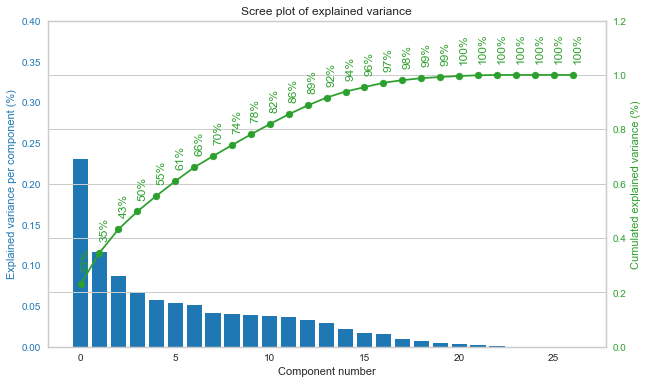

In [10]:
utpl.screePlot_2axis(profile, var_explained=0.8, filename="screeplot")

X_pca is scaled and reduced to 10 dimensions -> will be used as input for the clustering

Explained variance per principal components

In [11]:
#utpl.screePlot(profile, var_explained=0.8)

In [12]:
len(np.cumsum(pca.explained_variance_ratio_))

10

80% of the variance in explained by 9 components

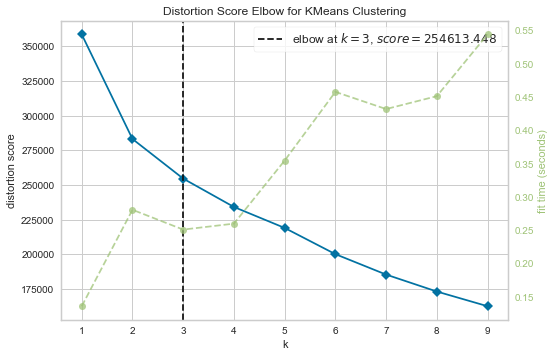

In [13]:
# elbow method
kelbow_visualizer(KMeans(), X_pca, k=(1,10));

In [14]:
# silhouette method
#kelbow_visualizer(KMeans(), X_pca, k=(2,10), metric='silhouette');

# 3. Modelling (Clustering with K-means)

In [15]:
imp.reload(utpi)
imp.reload(utpl)

<module 'utils_plots' from 'C:\\Users\\micka\\01_GitHub_mbastard\\TargetingCustomers_DAIB\\clustering\\./../utils\\utils_plots.py'>

Choose 3 clusters as the best number of clusters
Do not forget to use "1234" as seed

In [16]:
model = KMeans(n_clusters=3, random_state=utm.getSeed()).fit(X_pca)
kmeans_clusters = model.predict(X_pca)

# 4. Evaluation and Interpretation

In [17]:
imp.reload(utpi)
imp.reload(utpl)

<module 'utils_plots' from 'C:\\Users\\micka\\01_GitHub_mbastard\\TargetingCustomers_DAIB\\clustering\\./../utils\\utils_plots.py'>

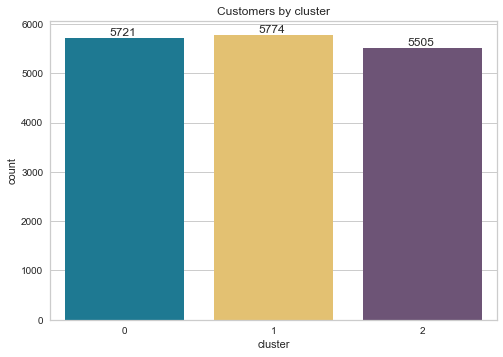

In [18]:
utpl.customersByClusters(profile, kmeans_clusters, filename="customersByCluster_v2")

In [19]:
df = profile.copy()
df['cluster'] = kmeans_clusters
df = df.melt(id_vars=['id_membership', 'cluster'])
df = df.query('cluster != -1').groupby(['cluster', 'variable']).mean().reset_index()
df[df.cluster==0]

,cluster,variable,value
0,0,age_cat_high,0.738682
1,0,age_cat_low,0.087397
2,0,age_cat_medium,0.173921
3,0,comp_rate_after_rec,0.071610
4,0,comp_rate_after_view,0.103522
5,0,gender_F,0.321273
6,0,gender_M,0.666667
7,0,gender_O,0.012061
8,0,income_cat_high,0.133019
9,0,income_cat_low,0.328439


In [20]:
profile_new = profile.copy()

Compute 'delta_spend_bogo\n_spend_exc_offer' and 'delta_spend_discount\n_spend_exc_offer' variables used for the interpretation

In [21]:
profile_new["delta_spend_bogo\n_spend_exc_offer"] = profile_new["prep_tot_aver_spend_bogo"] - profile_new["prep_tot_aver_spend_exc_offers"]
profile_new["delta_spend_discount\n_spend_exc_offer"] = profile_new["prep_tot_aver_spend_discount"] - profile_new["prep_tot_aver_spend_exc_offers"]

In [22]:
profile_new.columns

Index(['id_membership', 'prep_tot_aver_spend_exc_offers',
       'prep_tot_aver_reward', 'prep_comp_one_bogo', 'prep_comp_one_discount',
       'prep_tot_aver_spend_bogo', 'prep_tot_aver_spend_discount',
       'prep_recency', 'prep_T', 'prep_nb_of_transactions', 'prep_tot_spend',
       'prep_tot_aver_spend', 'not_sharing_pers_data', 'view_rate_after_rec',
       'comp_rate_after_view', 'comp_rate_after_rec', 'gender_F', 'gender_M',
       'gender_O', 'year_joined_2013_2014', 'year_joined_2015_2016',
       'year_joined_2017_2018', 'age_cat_high', 'age_cat_low',
       'age_cat_medium', 'income_cat_high', 'income_cat_low',
       'income_cat_medium', 'delta_spend_bogo\n_spend_exc_offer',
       'delta_spend_discount\n_spend_exc_offer'],
      dtype='object')

In [23]:
imp.reload(utpi)
imp.reload(utpl)

<module 'utils_plots' from 'C:\\Users\\micka\\01_GitHub_mbastard\\TargetingCustomers_DAIB\\clustering\\./../utils\\utils_plots.py'>

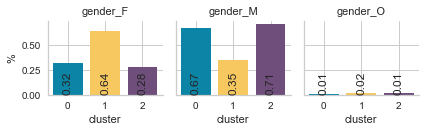

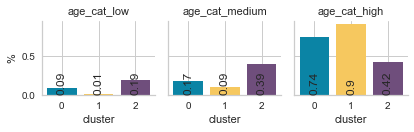

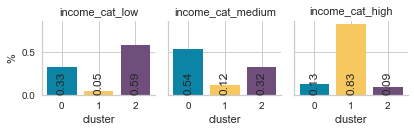

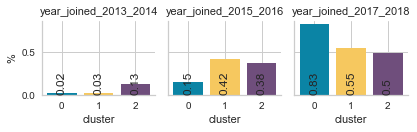

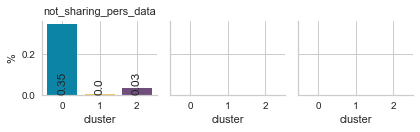

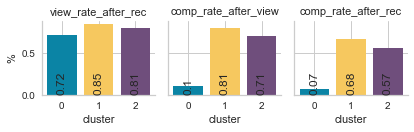

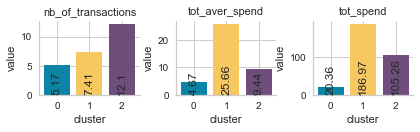

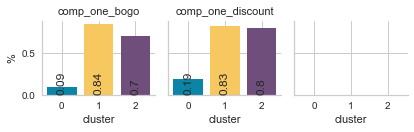

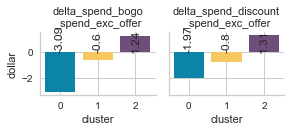

In [24]:
# List of variables to be plotted

opt_col_order = ['gender_F', 'gender_M', 'gender_O', 
                 'age_cat_low', 'age_cat_medium', 'age_cat_high',                  
                 'income_cat_low', 'income_cat_medium', 'income_cat_high', 
                 'year_joined_2013_2014', 'year_joined_2015_2016', 'year_joined_2017_2018',
                 'not_sharing_pers_data', ' ', ' ',
                 
                 'view_rate_after_rec', 'comp_rate_after_view', 'comp_rate_after_rec',
                 
                 'prep_nb_of_transactions', 'prep_tot_aver_spend', 'prep_tot_spend',
                 
                 #'prep_tot_aver_spend_exc_offers', 'prep_tot_aver_spend_bogo', 'prep_tot_aver_spend_discount', 
                 
                 'prep_comp_one_bogo', 'prep_comp_one_discount', ' ',
                 
                 'delta_spend_bogo\n_spend_exc_offer', 'delta_spend_discount\n_spend_exc_offer'#, 'prep_tot_aver_reward',                 prep_tot_spend
                 
                 ]

# List for sharing the same y axis or not

sharey_lst = [True, 
              True,
              True, 
              True,
              True, 
              True, 
              False, 
              True, 
              True
             ]

ylabel_lst = ["%", 
              "%", 
              "%", 
              "%", 
              "%", 
              "%", 
              "value",               
              "%",
              "dollar"
             ]

t = utpl.barPlotGrid_values(profile = profile_new.copy(), kmeans_clusters = kmeans_clusters, filename="Map_BarPlot", opt_col_order = opt_col_order,
                            sharey_lst = sharey_lst, ylabel_lst=ylabel_lst)

Share y Axis

### Yello Group - Mostly Women with high income who spend a lot and complete a lot of offers
* Mostly Women (65% Women + 35% Men)
* Mostly Old People (90%)
* Mostly High income (83%)
* Low and Medium seniority (joined mostly between 2015 and 2018)
* High view rate (i.e. 86 %)
* High completion rate after receiving offers (i.e. 68%)
* Medium number of transactions (i.e. 7.4)
* High total average spend (25.66 dollar)
* High total spend (186.97 dollar)
* Most have completed at least one bogo and discount offer (84% and 83% respectively)
* Spend slightly less on average while using bogo and discount offers. Spend even less when using discount offers. 

This group spent the most over the promotional period with a total spend of 191.39 dollar on average and a total average spend of 25.94 dollar on average. 

This group responds very well to promotionnal offers with a view rate of 86% and completion rate of 69 %.
We should keep sending promotionnals offers to this group.

However, this group spends slightly less on average while using bogo and discount offers. It spends even less when using discount offers. Therefore, we might want to send more bogo offers to reduce the cost of the promotional campaign.

### Purple Group - Mostly Men with low income who make a lot of transactions and spend more while completing offers
* Mostly Men (70% Men + 30% Women)
* Mostly middle age people and old people (38% + 43%)
* Mostly low income (57%) and medium income (34%)
* Low and Medium seniority (joined mostly between 2015 and 2018)
* High view rate (i.e. 82 %)
* Relatively high completion rate after receiving offers (i.e. 57%)
* High number of transactions (i.e. 12.5)
* Medium total average spend (9.44 dollar)
* High total spend (105.26 dollar)
* Most have completed at least one bogo and discount offer (70% and 80% respectively)
* Spend more on average while using bogo and discount offers. Spend slightly more when using discount offers. 

This group completed the highest number of transactions over the promotional period with 12.46 transactions on average.

This group responds also very well to promotionnal offers with a view rate of 82% and a completion rate of 57 %.
We should keep sending promotionnals offers to this group.

This group spends even more on average while completing offers (i.e. discount and bogo). This group completed more discount offers than bogo offers on verage and this group spends slightly more while completing discount offers. Therefore, we might want to send more discount offers to this group as they seem to be more responsive and they tend to spend more with this kind of promotion.

### Blue Group - Mostly men with medium income and low seniority who spend very little and even less while completing offers
* Moslty Men (67% of men and 33% of women)
* Mostly Old People (74%)
* Mostly medium income (54%) and low income (34%)
* Low seniority (joined mostly in 2017 and 2018)
* 35% of this group did not want to share their personal data (i.e. almost all the people who did want to share their personal data belong to this group)
* Relatively High view rate (i.e. 72 %)
* Very low completion rate after receiving offers (i.e. 7%)
* Low total average spend (4.67 dollar)
* Low total spend (20.36 dollar)
* Spend less on average while completing bogo and discount offers. Spend even less while completing bogo offers

This group completeted the lowest number of transactions over the promotional period with 5.17 transactions on average.

This group spent the least over the promotional period with a total spend of 20.36 dollar on average and a total average spend of 4.67 dollar on average. 

This group does not respond to promotionnal offers with a completion rate of 7 %.
We should stop sending promotionnals offers to this group.

Moreover, this group spends less on average while completing offers (i.e. discount and bogo) which means that it costs money for the company.
